In [1]:
%load_ext blackcellmagic

In [2]:
import os, pdb
import pandas as pd
import seaborn as sns
from typing import Tuple, Dict, List
from sklearn.linear_model import LogisticRegressionCV
# from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
import time, datetime
import numpy as np
import joblib
%matplotlib inline

# Parameters

In [3]:
TARGET_CUTOFF = 7.5
PROJECT_BASE_DIR = "/home/rohail/projects/imdb_ratings/"
model_save_dir = "models/"
data_dir = "data/raw/"
plot_write_dir = "reports/figures"

In [4]:
main_fname = "movies.csv"
df = pd.read_csv(os.path.join(PROJECT_BASE_DIR, data_dir, main_fname))
df.head()

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,NaN,Charles Tait,...,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,537,$ 2250,NaN,NaN,NaN,7.0,7.0
1,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,...,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.9,171,NaN,NaN,NaN,NaN,4.0,2.0
2,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,...,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,420,$ 45000,NaN,NaN,NaN,24.0,3.0
3,tt0002130,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",...,"Salvatore Papa, Arturo Pirovano, Giuseppe de L...",Loosely adapted from Dante's Divine Comedy and...,7.0,2019,NaN,NaN,NaN,NaN,28.0,14.0
4,tt0002199,"From the Manger to the Cross; or, Jesus of Naz...","From the Manger to the Cross; or, Jesus of Naz...",1912,1913,"Biography, Drama",60,USA,English,Sidney Olcott,...,"R. Henderson Bland, Percy Dyer, Gene Gauntier,...","An account of the life of Jesus Christ, based ...",5.7,438,NaN,NaN,NaN,NaN,12.0,5.0


# Exploratory analysis of target -- distribution, etc

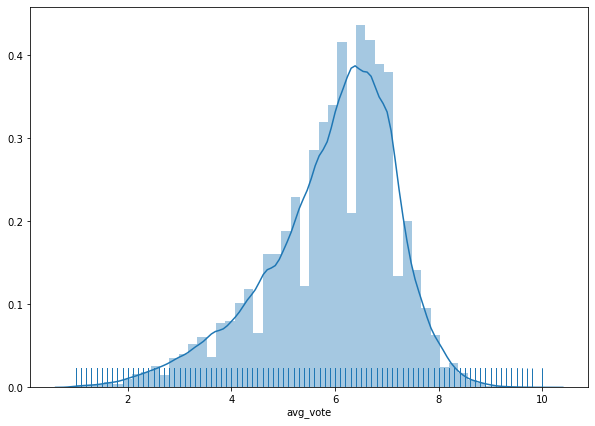

In [5]:
fig, ax = plt.subplots(figsize=(10,7))            
sns.distplot(df["avg_vote"], rug=True)

In [6]:
df["avg_vote"].describe()

count    81273.000000
mean         5.926587
std          1.243315
min          1.000000
25%          5.200000
50%          6.100000
75%          6.800000
max         10.000000
Name: avg_vote, dtype: float64

## Binarize the target

In [7]:
df.loc[:, "avg_vote_flag"] = (df.avg_vote >= TARGET_CUTOFF).astype(int)
class_balance = df.avg_vote_flag.value_counts()
percentage_of_total = float(
    (class_balance[class_balance.index == 1]) / class_balance.sum()
)
percent = "{:.2%}".format(percentage_of_total)

if class_balance.loc[1] < 5:
    print("Not fitting model due to lack of positive samples.")

print(
    f"The positive class represents {percent} of the total instances.\n"
    f"Positives: {class_balance.loc[1]}, negatives: {class_balance.loc[0]}"
)

The positive class represents 7.01% of the total instances.
Positives: 5696, negatives: 75577


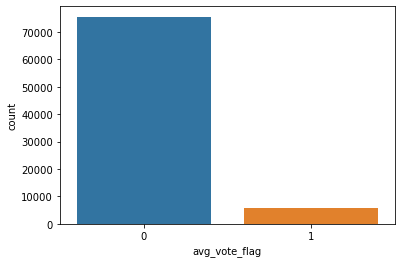

In [8]:
sns.countplot(df["avg_vote_flag"])

In [9]:
df.isnull().sum().sort_values()

imdb_title_id                0
votes                        0
avg_vote                     0
duration                     0
genre                        0
avg_vote_flag                0
year                         0
title                        0
date_published               0
original_title               0
country                     39
actors                      66
director                    73
language                   755
writer                    1493
description               2430
production_company        4325
reviews_from_users        7077
reviews_from_critics     10987
worlwide_gross_income    51381
budget                   58469
usa_gross_income         66179
metascore                68551
dtype: int64

# Enrich data with features

__TODO:__    
Movies:   
    * Normalize budget column to the same amount, but this needs to account for past currencies (pre euro...)
    * interact vote, budget, 
    * For foreign movies, check if it has been released in US (global vs local) or worldwide...
    * user/critics reviews -- where are they missing?   



In [10]:
idx_columns = ["imdb_title_id", "title", "original_title"]
target_column = "avg_vote_flag"

In [11]:
def enrich_with_features(
    df: pd.DataFrame, idx_columns: List[str], target_column: str, dummy: bool
) -> pd.DataFrame:
    if dummy:
        cols2keep = ["year", "duration"]
        select = idx_columns + cols2keep + [target_column]

    return df.loc[:, select].copy()


df_subset = enrich_with_features(df, idx_columns, target_column, dummy=True)
df_subset.head()

,imdb_title_id,title,original_title,year,duration,avg_vote_flag
0,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,70,0
1,tt0001892,Den sorte drøm,Den sorte drøm,1911,53,0
2,tt0002101,Cleopatra,Cleopatra,1912,100,0
3,tt0002130,L'Inferno,L'Inferno,1911,68,0
4,tt0002199,"From the Manger to the Cross; or, Jesus of Naz...","From the Manger to the Cross; or, Jesus of Naz...",1912,60,0


# Scaling data/dummy encoding, etc

In [12]:
def prepare_data_for_sklearn(df: pd.DataFrame, idx_columns):
    return df.drop(columns = idx_columns).copy()

df_model = prepare_data_for_sklearn(df_subset, idx_columns)

df_model.head()

,year,duration,avg_vote_flag
0,1906,70,0
1,1911,53,0
2,1912,100,0
3,1911,68,0
4,1912,60,0


# Train model


more important to get the high rating movies right --> so our classifier needs to get certain types of movies right    
class imbalance??

In [13]:
def summarise_model_performance(
    model: LogisticRegressionCV,
    x_train: pd.DataFrame,
    y_train: pd.DataFrame,
    x_test: pd.DataFrame,
    y_test: pd.DataFrame,
) -> plt.Figure:
    """
    Summarize model performance on train and test set as well as generate ROC plot for the test set

    Args:
        model: A trained LogisticRegressionCV object
        x_train: Train subset for features
        y_train: Train subset for target variable
        x_test: Test subset for features
        y_test: Test subset for target variable

    Returns:
        A matplotlib object visualizing ROC curve on test set
    """
    if isinstance(model, LogisticRegressionCV):
        print(f"Optimal C parameter: {model.C_}")

    y_train_scores = model.decision_function(x_train)
    y_test_scores = model.decision_function(x_test)
    auc_train = roc_auc_score(y_train, y_train_scores).round(3)
    auc_test = roc_auc_score(y_test, y_test_scores).round(3)
    print(f"AUC score on train set: {auc_train}")
    print(f"AUC score on test set : {auc_test}")
    fpr, tpr, auc_thresholds = roc_curve(y_test, model.predict_proba(x_test)[:, 1])
    roc_plt = plot_roc_curve(
        fpr, tpr, label=f"AUC score on test set: {auc_test} for chosen C: {model.C_[0]}"
    )

    return roc_plt


def plot_roc_curve(fpr: np.array, tpr: np.array, label=None) -> plt.Figure:
    """
    The ROC curve, modified from
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91

    Args:
        fpr: Increasing false positive rates such that element i is the false
        positive rate of predictions with score >= thresholds[i]
        tpr: Increasing true positive rates such that element i is the true
        positive rate of predictions with score >= thresholds[i].
        label: Title for the plot

    Returns:
        A matplotlib object visualizing ROC curve for provided tpr and fpr
    """
    roc_fig = plt.figure(figsize=(8, 8))
    plt.title("ROC Curve" if not label else label)
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], "k--")
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0, 1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    return roc_fig


def summarise_model_tuning(model: LogisticRegressionCV) -> plt.Figure:
    """
    Visualize how different values for the regularization parameter impact number of iterations to convergence and ROC
    AUC. Useful to determine optimal hyperparameter.

    Args:
        model: A trained LogisticRegressionCV

    Returns:
        A matplotlib object visualizing the effect of varying the regularization parameter
    """
    reg_fig, axes = plt.subplots(2, 1)
    axes[0].plot(model.Cs_, np.mean(model.scores_[1], axis=0), marker=".")
    axes[0].set_ylabel("ROC AUC")
    axes[1].plot(model.Cs_, np.mean(model.n_iter_[0], axis=0), marker=".")
    axes[1].set_ylabel("Number of iterations")
    axes[1].set_xlabel("Regularization C")
    plt.close()
    return reg_fig


def get_model_coefficients(
    model: LogisticRegressionCV, features: pd.DataFrame
) -> pd.DataFrame:
    """
    Retrieve model coefficients

    Args:
        model: A trained LogisticRegressionCV
        features: The pd.DataFrame containing features

    Returns:
        A pd.DataFrame containing the coefficients
    """
    df_coefs = pd.DataFrame(
        {"coeff_log_odds": np.concatenate((model.intercept_, model.coef_.flatten()))},
        index=["intercept"] + features.columns.tolist(),
    )
    df_coefs.loc[:, "coeff_odds_exponentiated"] = np.exp(df_coefs["coeff_log_odds"])

    is_selected_coefficient = ~np.isclose(df_coefs["coeff_log_odds"], 0)
    print(
        f"Coefficients selected: {is_selected_coefficient.sum()} "
        f"({is_selected_coefficient.mean():.2%})"
    )

    return df_coefs.reset_index()

In [14]:
def train_model(
    df_model: pd.DataFrame, parameters: Dict
) -> Tuple[LogisticRegressionCV, pd.DataFrame]:
    """
    This function fits a LogisticRegressionCV model from sklearn and returns the trained model
    and fitted coefficients to be visualized in a feature importance plot

    Args:
        df_model: A dataframe, which has already passed through scaling/one hot encoding, etc to be used for training
        the model. The target variable is collected from the parameters dictionary
        parameters: Contains training parameters as well as others needed for model fitting

    Returns:
        A List containing:
            1. Fitted LogisticRegressionCV object
            2. pd.DataFrame containing the fitted coefficients

    """
    # collect parameters
    target = parameters["target_variable"]
    test_set_size = parameters["test_set_size"]
    model_save_dir = parameters["model_save_dir"]
    #     pdb.set_trace()
    fit_params = parameters["training_parameters"]
    plot_write_dir = parameters.get("plot_write_dir")

    nl = "\n"
    print(
        f"Diagnostic plots for this model can be found in the following directory: {nl + plot_write_dir}",
        f"\nThe model itself is saved in the following directory: {model_save_dir}",
        "\n", sep="",
    )

    # Obtain scaled version of the data
    X = df_model.drop(columns=target).copy()
    y = df_model[target].copy()

    # Do the grid search on a part of the dataset, keep a part for validation
    x_train, x_test, y_train, y_test = train_test_split(
        X, y, test_size=test_set_size, stratify=y, random_state=123
    )

    start = time.time()

    classifier = LogisticRegressionCV(
        **fit_params,
        solver="saga",
        verbose=0,
        cv=4,
        random_state=123,
        scoring="roc_auc",
    )

    # NB: max_iter should be increased, because the current value 300 is often reached:
    # it suggests that fitting stops before convergence.
    classifier.fit(x_train, y_train)

    end = time.time()
    print(f"The training took {np.round((end - start), 3)} seconds","\n")
    value = datetime.datetime.fromtimestamp(end)
    joblib.dump(classifier, f"{model_save_dir}/{value.strftime('%Y_%m_%d_%H_%M_%S')}.joblib")

    # Worth checking how much the score differs between parameter values (Cs, l1_ratios),
    # and possibly between folds
    # print("Classifier scores", classifier.scores_)

    roc_fig = summarise_model_performance(classifier, x_train, y_train, x_test, y_test)

    # Show number of selected coefficient
    df_coefficients = get_model_coefficients(classifier, X)

    # Show figure of regularization Cs and n_iter
    reg_fig = summarise_model_tuning(classifier)

    # dump plots to disk
    plots = {"roc_fig.png": roc_fig, "reg_fig.png": reg_fig}

    # write the figures to disk
    for plot_name, plot in plots.items():
        plot.savefig(os.path.join(plot_write_dir, plot_name))

    return classifier, df_coefficients

Diagnostic plots for this model can be found in the following directory: 
/home/rohail/projects/imdb_ratings/reports/figures
The model itself is saved in the following directory: /home/rohail/projects/imdb_ratings/models/

The training took 5.353 seconds 

Optimal C parameter: [0.01]
AUC score on train set: 0.719
AUC score on test set : 0.718
Coefficients selected: 3 (100.00%)


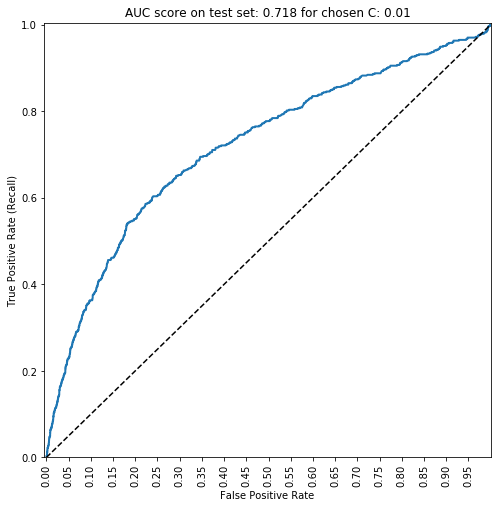

In [15]:
parameters = {
    "plot_write_dir": os.path.join(PROJECT_BASE_DIR, plot_write_dir),
    "model_save_dir": os.path.join(PROJECT_BASE_DIR, model_save_dir),
    "target_variable": "avg_vote_flag",
    "test_set_size": 0.1,
    "training_parameters": {
        "penalty": "l1",
        "Cs": [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1],
        "n_jobs": -1,
        "max_iter": 5000,
    },
}


classifier, df_coefficients = train_model(df_model, parameters)

In [16]:
classifier

LogisticRegressionCV(Cs=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1],
                     class_weight=None, cv=4, dual=False, fit_intercept=True,
                     intercept_scaling=1.0, l1_ratios=None, max_iter=5000,
                     multi_class='auto', n_jobs=-1, penalty='l1',
                     random_state=123, refit=True, scoring='roc_auc',
                     solver='saga', tol=0.0001, verbose=0)

In [17]:
df_coefficients.head()

,index,coeff_log_odds,coeff_odds_exponentiated
0,intercept,0.000041,1.000041
1,year,-0.002736,0.997267
2,duration,0.026934,1.027300


# Validate model

In [42]:
# black panther should be classified as bad...
# batman vs superman should be bad
#
test_movies = {
    "The Dark Knight",
    "Anchorman: The Legend of Ron Burgundy",
    "The Big Lebowski",
    "Batman v Superman: Dawn of Justice",
    "Black Panther",
    "Kabhi Khushi Kabhie Gham...",
    "3 Idiots",
    "The Intouchables",
    "Amélie",
    "The Matrix",
    "The Matrix Reloaded",
    "V for Vendetta",
    "Once Upon a Time... in Hollywood",
    "La vita è bella",
    "Die Hard",
    "Requiem for a Dream",
    "Terminator 3: Rise of the Machines",
    "The Terminator",
    "Terminator 2: Judgment Day",
    "Titanic",
    "Shutter Island",
    "Groundhog Day",
    "Love in Kilnerry",
    "Jinnah",
    "Jawani Phir Nahi Ani",
    "Bol",
    "Das letzte Mahl",
    "The Lives of Others",
    "Das Experiment",
}


def predict_on_test(
    model: LogisticRegressionCV,
    df_model: pd.DataFrame,
    df: pd.DataFrame,
    idx_columns: List[str],
    target_variable: str,
) -> pd.DataFrame:
    df_predict = df.loc[df.title.isin(test_movies)].copy()
    prediction_columns = list(set(df_model.columns) - {target_variable})
    df_predict.loc[:, "prediction"] = model.predict(
        df_predict.loc[:, prediction_columns].copy()
    )
    cols2drop = set(df_predict.columns) - set(idx_columns).union(
        {target_variable, "avg_vote", "prediction"}
    )
    return df_predict.drop(columns=cols2drop)


df_predict = predict_on_test(
    classifier, df_model, df, idx_columns, target_variable="avg_vote_flag"
)
pd.crosstab(df_predict.avg_vote_flag, df_predict.prediction)

prediction,0,1
avg_vote_flag,,
0,8,1
1,23,0


In [43]:
df_predict

,imdb_title_id,title,original_title,avg_vote,avg_vote_flag,prediction
4395,tt0036443,Titanic,Titanic,6.2,0,0
7460,tt0046435,Titanic,Titanic,7.0,0,0
18574,tt0080101,La vita è bella,La vita è bella,6.4,0,0
21010,tt0088247,The Terminator,The Terminator,8.0,1,0
23110,tt0095016,Die Hard,Die Hard,8.2,1,0
25513,tt0103064,Terminator 2: Judgment Day,Terminator 2: Judgment Day,8.5,1,0
26516,tt0107048,Groundhog Day,Groundhog Day,8.0,1,0
29578,tt0118715,The Big Lebowski,The Big Lebowski,8.1,1,0
29623,tt0118799,La vita è bella,La vita è bella,8.6,1,0
30262,tt0120338,Titanic,Titanic,7.8,1,0


> Model is mostly predicting 0. 

Possible remedies:   
* Class imbalance problem? 
* Add more Features

# Different types of movies: 
* English Comedy: will ferrel, big lebowski? 
* Low budget/indie movies:   
* Superhero movies (high budget, high viewership):  
* Global vs local viewership
* Famous producer/actor movies  

* How polarised is the voting (mean vs median of ratings) -> These movies will probably present more challenges